In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal

# Para detectar sincronismo.
from scipy import signal as sig
import random
import pandas as pd

In [2]:
def texttobin(input_string):
    bit_string=[]
    ascii_array=bytearray(input_string,'ascii')
    for i in ascii_array:
        bin_char=bin(i)
        byte=bin_char[2:]
        byte_size=len(byte)
        while(byte_size<8):
            byte='0'+byte
            byte_size=len(byte)
        for bit in byte:
            bit_string=np.append(bit_string,bit)
    return bit_string

In [26]:
# leitura de txt (header):

header = open('header.txt', 'r', encoding="utf-8")
header = header.read()
header = header.replace("[", "")
header = header.replace("]", "")
header = header.replace(",", "")

header = np.fromstring(header, dtype=int, sep=' ')
print(header)
print(type(header[2]))
print(len(header))

[1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0
 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1
 1]
<class 'numpy.int64'>
75


In [4]:
#header = header.astype(float)  
print(len(header))
print(header)
type(header[2])

75
[1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0
 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1
 1]


numpy.int64

In [5]:
print("Digite o número de modulações que o detector irá detectar (2 ou 4): ")
n = input()
n = int(n)

Digite o número de modulações que o detector irá detectar (2 ou 4): 
2


In [6]:
print("Digite a taxa de transmissão de preferência (Tb): ")
baudRate = input()
baudRate = int(baudRate)

Digite a taxa de transmissão de preferência (Tb): 
20


# 2-FSK (se n = 2)

In [49]:
# Leitura de .wav

data, Fs = sf.read('teste_2fsk.wav') 
print("Dados do áudio: ", data)
print("Tamanho dos dados: ", len(data))
print("Sample rate of the audio: ", Fs)

Dados do áudio:  [0.         0.99996948 0.9510498  ... 0.80899048 0.9135437  0.9781189 ]
Tamanho dos dados:  1528801
Sample rate of the audio:  24000


In [50]:
# Cálculo de up sample (amostras por símbolo).

up_sample = Fs/baudRate
print("Amostras por símbolo: ", up_sample)

Amostras por símbolo:  1200.0


In [51]:
# modulação do header.

F1=800
F2=1200
#t_wave=np.arange(0,1/baudRate,1/Fs)         # Limita meu sinal em um tempo determinado.

header_modulado = []
tam = len(header)
#cosseno_F1 = np.cos(2*np.pi*F1*t_wave)
#cosseno_F2 = np.cos(2*np.pi*F2*t_wave)

for i in range(0, tam, 1):
    t_wave = np.arange((i*1/baudRate),(1/baudRate)+(i*1/baudRate),1/Fs)
    cosseno_F1 = np.cos(2*np.pi*F1*t_wave)
    cosseno_F2 = np.cos(2*np.pi*F2*t_wave)
    
    if header[i]==0:
        x = (cosseno_F1)
        header_modulado = np.append(header_modulado, x)
    elif header[i]==1:
        x = (cosseno_F2)
        header_modulado = np.append(header_modulado, x)
        
print(header_modulado)
len(header_modulado)

[1.         0.95105652 0.80901699 ... 0.58778525 0.80901699 0.95105652]


90032

array([1.        , 0.95105652, 0.80901699, ..., 0.58778525, 0.80901699,
       0.95105652])

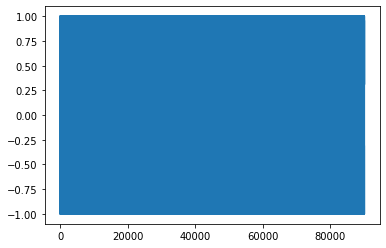

In [52]:
# Plot do header modulado (não deu para ver a mudança de frequência).

t = np.arange(0,len(header_modulado),1)  
fig = plt.figure()
plt.plot(t, header_modulado)
fig.savefig('plot.png')
header_modulado

In [53]:
# Aqui eu tenho que descobrir onde o sinal começa, ou seja, achar o cabeçalho e ver onde sinal começa (start_bit). 
# Isso pode ser feito com uma função de correlação (o valor deve ser máximo para o atraso estar sincronizado).

corr = np.correlate(data,header_modulado,mode='valid')
corr_position = np.argmax(corr)
start_bit = corr_position

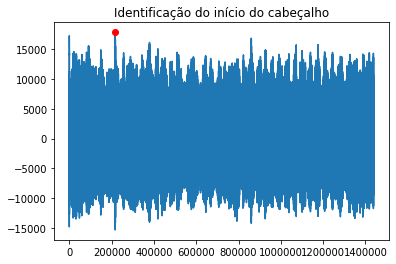

In [54]:
# Plot da correlação cruzada

plt.plot(corr)
plt.title('Identificação do início do cabeçalho')
plt.plot(corr_position,corr[corr_position],'or')
plt.show()

In [55]:
# Start bit só vamos saber depois de fazer o sincronismo.

print("Amostra de começo da mensagem: ", start_bit)

Amostra de começo da mensagem:  217169


In [56]:
len(header_modulado)

90032

In [57]:
# Cálculos para plotar o sinal recebido. (não é necessário, nem decisivo para a demodulação)

start = start_bit #+ len(header_modulado)    # ACHO que o start_bit dá a primeira posição do header. Para achar
                                             # onde a mensagem começa, tenho que somar isso ao tamanho do 
                                                # header. Se der errado tenta do outro jeito.

In [58]:
# Pegar dados a partir de onde começa a mensagem.

data = data[start:]
print(data)
print(len(data))

[-0.809021   -0.95108032 -1.         ...  0.80899048  0.9135437
  0.9781189 ]
1311632


In [59]:
# debug

print(baudRate, 10/baudRate)
print(Fs, int((10/baudRate)*Fs))
print(data)
len(data)

20 0.5
24000 12000
[-0.809021   -0.95108032 -1.         ...  0.80899048  0.9135437
  0.9781189 ]


1311632

In [60]:
# Construção das ondas da portadora do 2-FSK. Cada "ramo" com uma frequência.

F1=800
F2=1200
t_wave=np.arange(0,1/baudRate,1/Fs)

wave1=np.cos(2*np.pi*F1*t_wave)
wave2=np.cos(2*np.pi*F2*t_wave)

In [61]:
# debug

print(wave2)
print(np.flip(wave2))       # Precisa-se inverter pq o filtro casado é h(-t).

[1.         0.95105652 0.80901699 ... 0.58778525 0.80901699 0.95105652]
[0.95105652 0.80901699 0.58778525 ... 0.80901699 0.95105652 1.        ]


In [62]:
# Aplicação do filtro casado + média móvel.

casado_1=np.convolve(data,np.flip(wave1))
casado_1=np.convolve(np.abs(casado_1),np.ones((int(len(t_wave)/2))))
casado_2=np.convolve(data,np.flip(wave2))
casado_2=np.convolve(np.abs(casado_2),np.ones((int(len(t_wave)/2))))

In [63]:
# debug

len(casado_1)            # PORQUE depois da convolução o vetor aumenta de tamanho?

1313430

In [64]:
# Amostragem do filtro casado a cada período de bit. Pego só última amostra para representar meu símbolo.
# Por causa da média móvel e da envoltória, esse ponto que eu pegar vai ser meu símbolo.

t = np.arange(0,len(data)/Fs,1/Fs)

step=int(Fs/baudRate)

amostra_casado1=casado_1[step::step]
amostra_casado2=casado_2[step::step]

t_amostra=np.arange(step/Fs,t[-1]+step/Fs,step/Fs)
len(t_amostra)

1094

In [65]:
print(len(t_amostra))
len(amostra_casado1)
#step

1094


1094

In [66]:
print(len(casado_1))
t

1313430


array([0.00000000e+00, 4.16666667e-05, 8.33333333e-05, ...,
       5.46512083e+01, 5.46512500e+01, 5.46512917e+01])

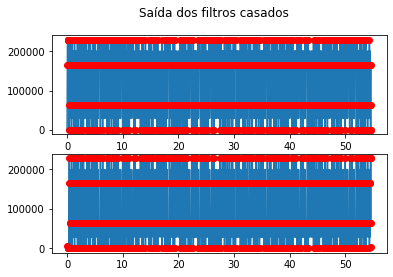

In [67]:
# Plot da saída dos filtros casados.

t = np.arange(0,len(data)/Fs,1/Fs) 

fig, axs = plt.subplots(2)
fig.suptitle('Saída dos filtros casados')
axs[0].plot(t,casado_1[0:len(t)])
axs[0].plot(t_amostra,amostra_casado1[0:len(t_amostra)],'or')
axs[1].plot(t,casado_2[0:len(t)])
axs[1].plot(t_amostra,amostra_casado2[0:len(t_amostra)],'or')
plt.show()
fig.savefig('saida_casada.png')

In [68]:
# debug

print(step)
amostra_casado2

1200


array([6.87504221e+03, 2.69195521e-10, 2.69195521e-10, ...,
       2.27293879e+05, 6.30972351e+04, 2.44107005e+03])

In [69]:
# Coparação posição a posição do vetor de saída de cada filtro.

a1 = len(amostra_casado1)
a2 = len(amostra_casado2)
vetor_final = []
for i in range(0, a1, 1):
    if amostra_casado1[i]>amostra_casado2[i]:
        vetor_final.append(0)
    elif amostra_casado1[i]<amostra_casado2[i]:
        vetor_final.append(1)
        
print(vetor_final)

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 

In [70]:
print(len(vetor_final))
print(type(vetor_final))

1094
<class 'list'>


# 4FSK ( se n = 4)

In [73]:
# Leitura de .wav

data, Fs = sf.read('teste_4fsk.wav') 
print("Dados do áudio: ", data)
print("Tamanho dos dados: ", len(data))
print("Sample rate of the audio: ", Fs)

Dados do áudio:  [0.         0.99996948 0.96591187 ... 0.58776855 0.80899048 0.9510498 ]
Tamanho dos dados:  764401
Sample rate of the audio:  24000


In [74]:
# Portadoras da 4-FSK

F1=600
F2=800
F3=1000
F4=1200

t_wave=np.arange(0,1/baudRate,1/Fs)

wave1=np.cos(2*np.pi*F1*t_wave)
wave2=np.cos(2*np.pi*F2*t_wave)
wave3=np.cos(2*np.pi*F3*t_wave)
wave4=np.cos(2*np.pi*F4*t_wave)

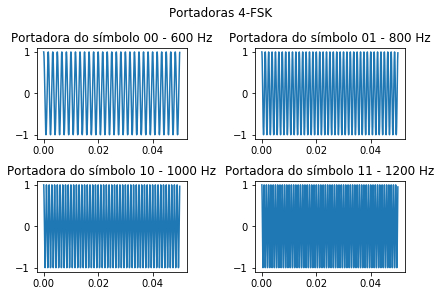

In [75]:
#Apresentação das portadoras
fig, axs = plt.subplots(2,2,constrained_layout=True)
fig.suptitle('Portadoras 4-FSK')
axs[0,0].plot(t_wave,wave1)
axs[0,0].set_title('Portadora do símbolo 00 - 600 Hz')
axs[0,1].plot(t_wave,wave2)
axs[0,1].set_title('Portadora do símbolo 01 - 800 Hz')
axs[1,0].plot(t_wave,wave3)
axs[1,0].set_title('Portadora do símbolo 10 - 1000 Hz')
axs[1,1].plot(t_wave,wave4)
axs[1,1].set_title('Portadora do símbolo 11 - 1200 Hz')
plt.show()

In [76]:
# Modulação do header. No caso do 4fsk, a gente precisa agrupar de dois em dois bits para representar cada 
# simbolo. Depois fazemos uma modulação.

F1=600
F2=800                                      # FAZER - A MESMA IDEIA PARA OS 4 SIMBOLOS.
F3=1000                                       # Mas dessa vez eu preciso separar todos os bits em pares, cada um sendo um simbolo.
F4=1200
#t_wave=np.arange(0,1/baudRate,1/Fs)         # Limita meu sinal em um tempo determinado.

b = [1]

header = np.append(header,b)

header_modulado = []
tam = len(header)
#cosseno_F1 = np.cos(2*np.pi*F1*t_wave)
#cosseno_F2 = np.cos(2*np.pi*F2*t_wave)

for i in range(0, tam, 2):
    t_wave = np.arange((i*1/baudRate),(1/baudRate)+(i*1/baudRate),1/Fs)
    cosseno_F1 = np.cos(2*np.pi*F1*t_wave)
    cosseno_F2 = np.cos(2*np.pi*F2*t_wave)
    cosseno_F3 = np.cos(2*np.pi*F3*t_wave)
    cosseno_F4 = np.cos(2*np.pi*F4*t_wave)
    
    if header[i]==0 and header[i+1]==0:
        x = (cosseno_F1)
        header_modulado = np.append(header_modulado, x)
    elif header[i]==0 and header[i+1]==1:
        x = (cosseno_F2)
        header_modulado = np.append(header_modulado, x)
    elif header[i]==1 and header[i+1]==1:
        x = (cosseno_F3)
        header_modulado = np.append(header_modulado, x)
    elif header[i]==1 and header[i+1]==0:
        x = (cosseno_F4)
        header_modulado = np.append(header_modulado, x)
        
print(header_modulado)
len(header_modulado)

[1.         0.96592583 0.8660254  ... 0.70710678 0.8660254  0.96592583]


45616

In [77]:
# Aqui eu tenho que descobrir onde o sinal começa, ou seja, achar o cabeçalho e ver onde sinal começa (start_bit). 
# Isso pode ser feito com uma função de correlação (o valor deve ser máximo para o atraso estar sincronizado).

corr = np.correlate(data,header_modulado,mode='valid')
corr_position = np.argmax(corr)
start_bit = corr_position

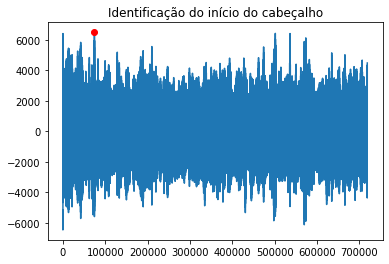

In [78]:
#Plot da correlação cruzada

plt.plot(corr)
plt.title('Identificação do início do cabeçalho')
plt.plot(corr_position,corr[corr_position],'or')
plt.show()

In [79]:
# Start bit só vamos saber depois de fazer o sincronismo.

print("Bit de começo da mensagem: ", start_bit)

Bit de começo da mensagem:  74387


In [80]:
start = start_bit #+len(header_modulado)

In [81]:
# Pegar dados a partir de onde começa a mensagem.

data = data[start:]
print(data)
print(len(data))

[-0.97814941 -0.91357422 -0.809021   ...  0.58776855  0.80899048
  0.9510498 ]
690014


In [82]:
casado_1=np.convolve(data,np.flip(wave1))
casado_2=np.convolve(data,np.flip(wave2))
casado_3=np.convolve(data,np.flip(wave3))
casado_4=np.convolve(data,np.flip(wave4))

In [83]:
#Amostragem do filtro casado a cada período de bit

t = np.arange(0,len(data)/Fs,1/Fs)

step=int(Fs/baudRate)

amostra_casado1=casado_1[step::step]
amostra_casado2=casado_2[step::step]
amostra_casado3=casado_3[step::step]
amostra_casado4=casado_4[step::step]
t_amostra=np.arange(step/Fs,t[-1]+step/Fs,step/Fs)

In [84]:
amostra_casado1

array([ 2.27905595e+00, -2.77637301e+02,  2.96451714e+00, -2.75358245e+02,
        5.24357309e+00, -2.77637301e+02, -2.72393728e+02,  2.96451714e+00,
        2.27905595e+00, -3.84343109e-01,  3.84343109e-01, -2.27905595e+00,
        2.27905595e+00, -3.84343109e-01, -4.32215494e-13, -1.89471284e+00,
        2.27905595e+00,  4.78495824e-14, -2.27905595e+00, -1.39797932e-13,
        1.89471284e+00, -1.89471284e+00, -2.75358245e+02,  2.96451714e+00,
        2.27905595e+00, -2.27905595e+00, -1.39797932e-13, -2.75358245e+02,
        5.24357309e+00, -2.77637301e+02, -2.72393728e+02,  2.96451714e+00,
        2.27905595e+00, -2.27905595e+00, -2.75358245e+02,  2.96451714e+00,
        2.27905595e+00, -2.27905595e+00, -1.39797932e-13, -1.39797932e-13,
        1.89471284e+00, -2.77252958e+02,  4.85922998e+00, -1.89471284e+00,
        1.89471284e+00, -1.89471284e+00, -2.75358245e+02,  2.96451714e+00,
        2.27905595e+00, -2.77637301e+02,  2.96451714e+00, -1.39797932e-13,
        1.89471284e+00, -

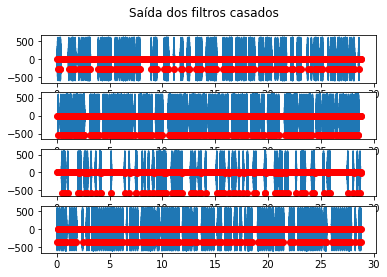

In [85]:
fig, axs = plt.subplots(4)
fig.suptitle('Saída dos filtros casados')
axs[0].plot(t,casado_1[0:len(t)])
axs[0].plot(t_amostra,amostra_casado1,'or')
axs[1].plot(t,casado_2[0:len(t)])
axs[1].plot(t_amostra,amostra_casado2,'or')
axs[2].plot(t,casado_3[0:len(t)])
axs[2].plot(t_amostra,amostra_casado3,'or')
axs[3].plot(t,casado_4[0:len(t)])
axs[3].plot(t_amostra,amostra_casado4,'or')
plt.show()

In [99]:
# Comparação posição a posição do vetor de saída de cada filtro.

a1 = len(amostra_casado1)
a2 = len(amostra_casado2)
vetor_final4 = []

for i in range(0, a1, 1):
    if amostra_casado1[i]>amostra_casado2[i] and amostra_casado1[i]>amostra_casado3[i] and amostra_casado1[i]>amostra_casado4[i]:        
        vetor_final4 = np.append(vetor_final4, [0, 0])
    elif amostra_casado2[i]>amostra_casado1[i] and amostra_casado2[i]>amostra_casado3[i] and amostra_casado2[i]>amostra_casado4[i]:
        vetor_final4 = np.append(vetor_final4, [0, 1])
    elif amostra_casado3[i]>amostra_casado1[i] and amostra_casado3[i]>amostra_casado2[i] and amostra_casado3[i]>amostra_casado4[i]:
        vetor_final4 = np.append(vetor_final4, [1, 1])
    elif amostra_casado4[i]>amostra_casado1[i] and amostra_casado4[i]>amostra_casado2[i] and amostra_casado4[i]>amostra_casado3[i]:
        vetor_final4 = np.append(vetor_final4, [1, 0])
        
print(vetor_final4)
vetor_final4 = vetor_final4.astype(int)

[0. 0. 1. ... 0. 1. 0.]


In [101]:
print(type(vetor_final4))
vetor_final4 = list(vetor_final4)
print(len(vetor_final4))
print(vetor_final4)

<class 'list'>
1152
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1